# Machine Learning - Assignment 3

## Artificial Neural Network

The aim of the assignment is to implement an artificial neural network (mostly) from scratch. This includes implementing or fixing the following:

* Add support for additional activation functions and their derivatives.
* Add support for loss functions and their derivative.
* Add the use of a bias in the forward propagation.
* Add the use of a bias in the backward propagation.

In addition, you will we doing the following as well:

* Test the algorithm on 3 datasets.
* Compare neural networks with and without scaling.
* Hyper-parameter tuning.

The forward and backward propagation is made to work through a single layer, and are re-used multiple times to work for multiple layers.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the implementation.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, you might find yourself going back and and forth to change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
# We set seed to better reproduce results later on.
np.random.seed(12345)
from sklearn.model_selection import StratifiedShuffleSplit

## Neural Network utility functions

### 1) Activation functions

Below is some setup for choosing activation function. Implement 2 additional activation functions, "ReLU" and one more of your choosing.

In [2]:
# Activation functions
def activate(activations, selected_function="none"):
    
    if selected_function == "none":
        y = activations
    elif selected_function == "relu":
        y = np.maximum(activations,0)  # ReLU
    elif selected_function == "sigmoid":
        y = 1 / (1 + np.exp(-activations))  # Sigmoid
    return y

In [3]:
# TODO Test your activation functions, is the returning values what you expect?
activations = np.array([-1, 0, 1, 2])
print(activate(activations, "relu"))
print(activate(activations, "sigmoid"))

[0 0 1 2]
[0.26894142 0.5        0.73105858 0.88079708]


### 2) Activation function derivatives

Neural networks need both the activation function and its derivative. Finish the code below.

In [4]:
def d_activate(activations, selected_function="none"):
    if selected_function == "none":
        dy = np.ones_like(activations)
    elif selected_function == "relu":
        dy = np.where(activations > 0, 1, 0)
    elif selected_function == "sigmoid":
        dy = activations * (1 - activations)  # Derivative of sigmoid
    return dy

In [5]:
# TODO Test your activation function derivatives, is the returning values what you expect?
activations = np.array([-1, 0, 1, 2])
print(d_activate(activations, "relu"))
print(d_activate(activations, "sigmoid"))

[0 0 1 1]
[-2  0  0 -2]


### 3) Loss functions

To penalize the network when it predicts incorrect, we need to meassure how "bad" the prediction is. This is done with loss-functions.

Similar as with the activation functions, the loss function needs its derivative as well.

Finish the MSE_loss (Mean Squared Error loss), as well as adding one additional loss function.

In [6]:
# This is the loss for a set of predictions y_hat compared to a set of real valyes y
def MSE_loss(y_hat, y):
    return 1/2 * np.mean(np.square(y_hat - y, dtype=np.float64))


# TODO: Choose another loss function and implement it
def huber_loss(y_hat, y):
    delta = 1.0
    error = np.abs(y_hat - y)
    loss = np.where(error <= delta, 0.5 * error ** 2, delta * (error - 0.5 * delta))
    return np.mean(loss)


The derivatives of the loss is with respect to the predicted value **y_hat**.

In [7]:
def d_MSE_loss(y_hat, y):
    m = y.shape[0]
    return 1./m * (y_hat-y)

# TODO: Choose another loss function and implement it
def d_huber_loss(y_hat, y):
    delta=1.0
    error=y-y_hat
    if np.abs(error)<=delta:
        dy = -error
    else:
        dy = -delta*np.sign(error)
    return dy

In [8]:
y_hat = np.array([0.5, 0.8, 0.1])
y = np.array([1, 1, 0])
print(MSE_loss(y_hat, y))  # Example output
print(huber_loss(y_hat, y))  # Example output


0.049999999999999996
0.049999999999999996


### 4) Forward propagation

The first "fundamental" function for neural networks is to be able to propagate the data forward through the neural network. We will implement this function here.

In [9]:
def propagate_forward(weights, activations, bias, activation_function="none"):
    weights = np.asarray(weights, dtype=np.float64)  # Ensure NumPy array
    activations = np.asarray(activations, dtype=np.float64)  # Ensure NumPy array
    bias = np.asarray(bias, dtype=np.float64)
    
    new_activations = activate(np.dot(activations,weights)+bias,activation_function)
    return new_activations

### 5) Back-propagation

To be able to train a neural network, we need to be able to propagate the loss backwards and update the weights. We will implement this function here.

In [10]:
def propagate_backward(weights, activations,bias, dl_dz, activation_function="none"):
    #dot_product = np.dot(activations, weights) + bias
    d_loss= d_activate(np.dot(activations, weights) + bias, activation_function) * dl_dz
    d_weights = np.dot(activations.T, d_loss)
    d_bias = np.sum(d_loss, axis=0, keepdims=True)
    d_activation = np.dot(d_loss, weights.T)
    
    return d_weights, d_bias, d_activation



## Neural network implementation

### 6) Fixing the neural network

Below is a class implementation of a MLP neural network. This implementation is still lacking several areas that are needed for the network to be robust and function well. Your task is to improve and fix it with the following:

1. Add a bias to the activation functions, and make sure the bias is also updated during training. 
2. Add a function that trains the network using minibatches (such that the neural network trains on a few samples at a time). 
3. Make use of an validation set in the training function. The model should stop training when the loss starts to increase for the validatin set. This feature should be able to be turned on and off to test the difference.


In [11]:
class NeuralNet(object):
    
    def __init__ (self, input_dim, output_dim, neurons = []):
        
        self.weights = [np.random.normal(0,0.1,(n,m)) for n,m in zip([input_dim] + neurons, neurons + [output_dim])]
        self.biases = [np.random.normal(0, 0.1, (1, m)) for m in neurons + [output_dim]]
        self.activation_functions = ["relu"] * len(neurons) + ["none"]
        
    
    def forward(self, x):
        for i,(layer_weights, layer_bias, layer_activation_function) in enumerate(zip(self.weights, self.biases, self.activation_functions)):
            x = propagate_forward(layer_weights, x, layer_bias, layer_activation_function)
        return x
    
    def adjust_weights(self, x, y, learning_rate=1e-4):
        # Forward pass
        activation = x
        activation_history = []
        
        for layer_weights, layer_bias, layer_activation_function in zip(self.weights, self.biases, self.activation_functions):
            activation_history.append(activation)
            activation = propagate_forward(layer_weights, activation, layer_bias, layer_activation_function)
        
        loss = MSE_loss(activation, y)
        d_activations = d_MSE_loss(activation, y)
        
        # Backward pass
        for i,(layer_weights, layer_bias, layer_activation_function,previous_activations) in enumerate(reversed(list(zip(self.weights, self.biases,self.activation_functions, activation_history)))):
            
            d_weights, d_bias,d_activations = propagate_backward(layer_weights,previous_activations,layer_bias, d_activations, layer_activation_function)
            
            self.weights[-(i+1)] -= learning_rate * d_weights
            self.biases[-(i+1)] -= learning_rate * d_bias
        
        return loss
        
    def calculate_accuracy(self, y_true, y_pred):
        predicted_classes = np.argmax(y_pred, axis=1)
        true_classes = np.argmax(y_true, axis=1)
        accuracy = np.mean(predicted_classes == true_classes)
        #print(f"y_true: {y_true}, y_pred: {y_pred},predicted_classes: {predicted_classes}, true_classes: {true_classes},accuracy: {accuracy}")
        return accuracy

    def train_net(self, x, y,x_test=None,y_test=None, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=False):
        losses = []
        accuracies = []
        split = int(len(x) * 0.8)
        if use_validation_data:
            x_train, x_val = x[:split], x[split:]
            y_train, y_val = y[:split], y[split:]
        else:
            x_train, y_train = x, y
            
        for epoch in range(epochs):
            indices = np.arange(len(x_train))
            np.random.shuffle(indices)
            x_shuffled = x_train[indices]
            y_shuffled = y_train[indices]
            epoch_losses = []
            epoch_accuracies = []
            for i in range(0, len(x_train), batch_size):
                x_batch = x_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                loss = self.adjust_weights(x_batch, y_batch,learning_rate)
                if x_test is not None and y_test is not None:
                    y_pred = self.forward(x_test)
                    accuracy = self.calculate_accuracy(y_test, y_pred)
                    epoch_accuracies.append(accuracy)
                epoch_losses.append(loss)
            avg_loss = np.mean(epoch_losses)
            losses.append(avg_loss)
            if x_test is not None and y_test is not None:
                avg_accuracy = np.mean(epoch_accuracies)
                accuracies.append(avg_accuracy)
            #print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}")
        return losses, accuracies

                
  
	


## Train Neural Networks

### 7) Simple test

In this a very simple test for you to use and toy around with before using the datasets.

Make sure to test both the **adjust_weights** function and the **train_net** function. What is the difference between the two?

Also, be sure to **plot the loss for each epoch** to see how the network training is progressing!

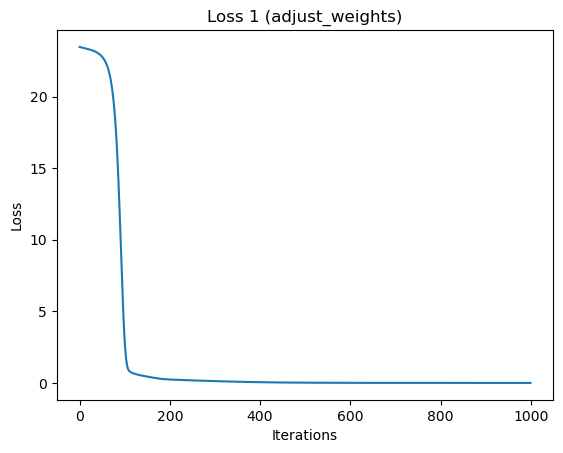

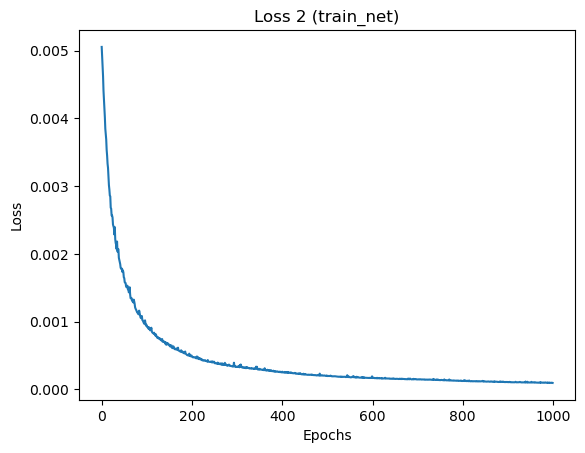

In [12]:
n = 1000
d = 4

k = np.random.randint(0, 10, (d, 1))
x = np.random.normal(0, 1, (n, d))
y = np.dot(x, k) + 0.1 + np.random.normal(0, 0.01, (n, 1))

nn = NeuralNet(d, 1, [18, 12])

# Lowered learning rate to 0.001
loss_1 = [nn.adjust_weights(x, y, learning_rate=0.01) for _ in range(1000)]

loss_2,acc = nn.train_net(x, y, epochs=1000, batch_size=32, learning_rate=0.01)

# Plot Loss 1
plt.plot(loss_1)
plt.title("Loss 1 (adjust_weights)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# Plot Loss 2
plt.plot(loss_2)
plt.title("Loss 2 (train_net)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Real test and preprocessing

When using real data and neural networks, it is very important to scale the data between smaller values, usually between 0 and 1. This is because neural networks struggle with larger values as input compared to smaller values. 

To test this, we will use our first dataset and test with and without scaling.

Similar as with assignment 2, we will use the scikit-learn library for this preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

### 8) Dataset 1: Wine - with and without scaling

Wine dataset: https://archive.ics.uci.edu/dataset/109/wine

Train two neural network, one with scaling and one without. Are we able to see any difference in training results or loss over time?

**Note:** Do not train for to many epochs (more than maybe 50-100). The network might "learn" anyway in the end, but you should still be able to see a difference when training.

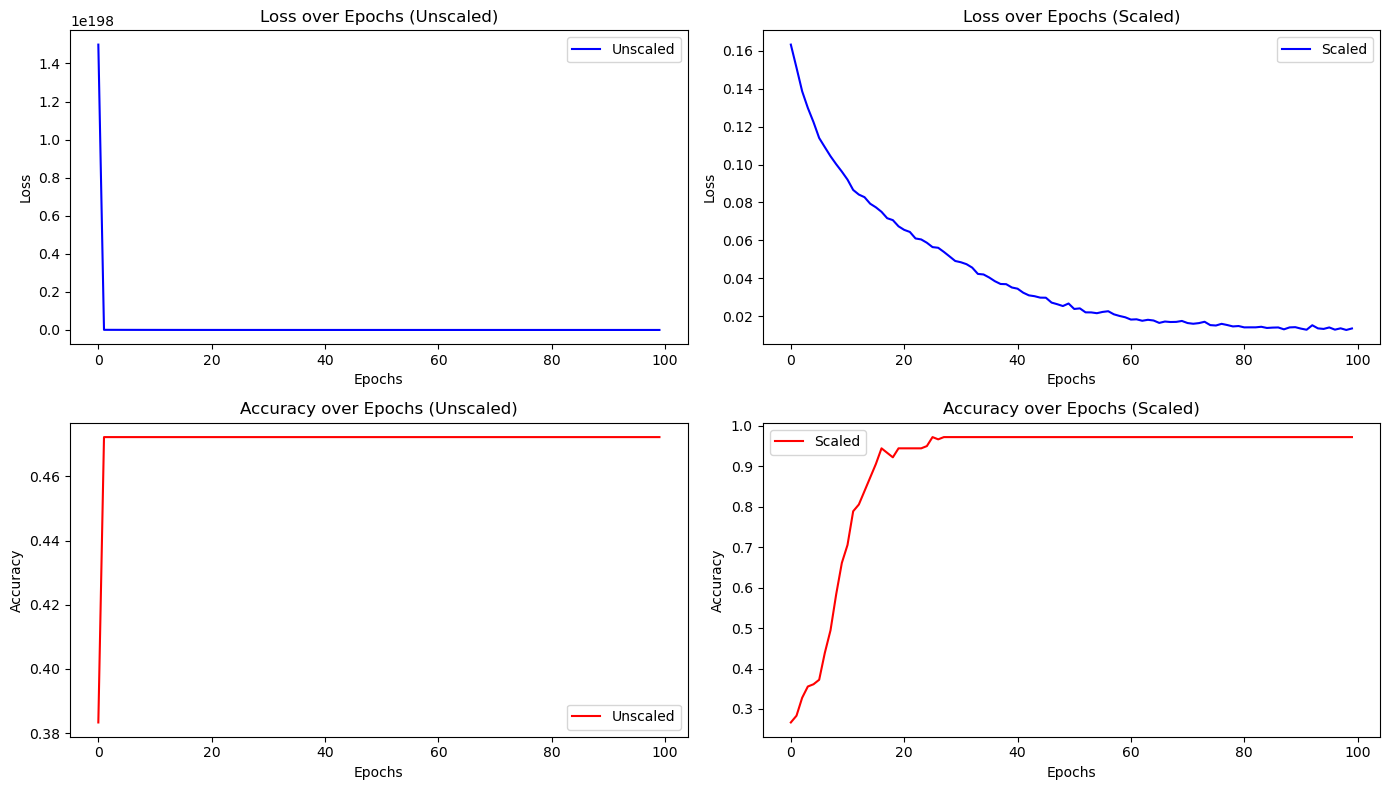

In [20]:
data_wine = pd.read_csv("wine.csv").to_numpy()[1:]  
X = data_wine[:, :-1].astype(float)
y = data_wine[:, -1].reshape(-1, 1)

y = y.astype(int)
y = y - 1

n_classes = len(np.unique(y))  
y_encoded = np.eye(n_classes)[y.astype(int).reshape(-1)]


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

import matplotlib.pyplot as plt

def main_wine():
    nn_unscaled = NeuralNet(X_train.shape[1], n_classes, [64,32])
    loss_history_unscaled, acc_history_unscaled = nn_unscaled.train_net(X_train, y_train, X_test, y_test, batch_size=32, epochs=100, learning_rate=0.01, use_validation_data=False)
    
    nn_scaled = NeuralNet(X_train.shape[1], n_classes, [64,32])
    loss_history_scaled, acc_history_scaled = nn_scaled.train_net(X_train_scaled, y_train, X_test_scaled, y_test, batch_size=32, epochs=100, learning_rate=0.01, use_validation_data=False)
    
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 2, 1)
    plt.plot(loss_history_unscaled, label='Unscaled', color='blue')
    plt.title('Loss over Epochs (Unscaled)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(loss_history_scaled, label='Scaled', color='blue')
    plt.title('Loss over Epochs (Scaled)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(acc_history_unscaled, label='Unscaled', color='red')
    plt.title('Accuracy over Epochs (Unscaled)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(acc_history_scaled, label='Scaled', color='red')
    plt.title('Accuracy over Epochs (Scaled)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

main_wine()

### Real data and hyper-parameter tuning

Now we are going to use real data, preprocess it, and do hyper-parameter tuning.

Choose two hyper-parameters to tune to try and achive an even better result.

**NOTE:** Changing the number of epochs should be part of the tuning, but it does not count towards the two hyper parameters.

### 9) Dataset 2: Mushroom

Mushroom dataset: https://archive.ics.uci.edu/dataset/73/mushroom

Note: This dataset has one feature with missing values. Remove this feature.

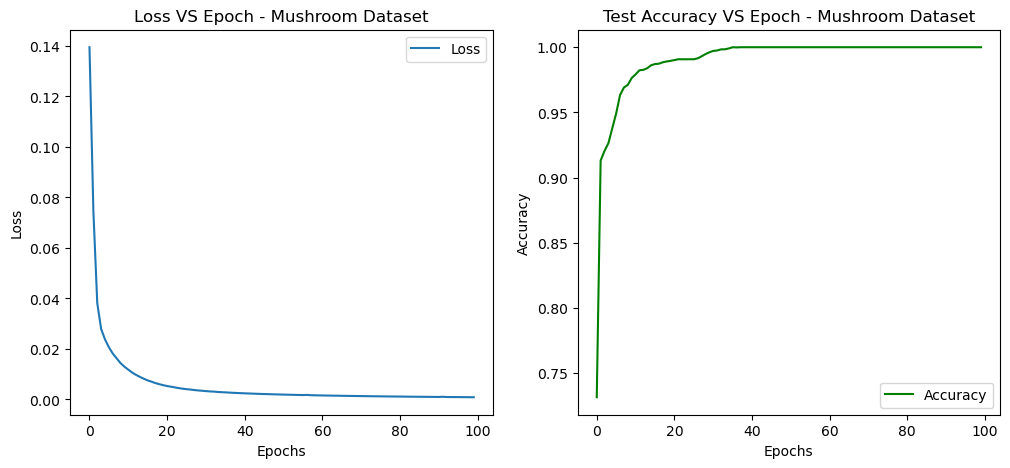

In [14]:
data_mushroom = pd.read_csv("mushroom.csv")
data_mushroom = data_mushroom.dropna()

data_mushroom = data_mushroom.drop(columns=['veil-type'], errors='ignore')

label_encoders = {}
for col in data_mushroom.columns:
    le = LabelEncoder()
    data_mushroom[col] = le.fit_transform(data_mushroom[col])
    label_encoders[col] = le

X_data_mushroom = data_mushroom.drop("edible", axis=1).values
y_data_mushroom = np.eye(2)[data_mushroom.iloc[:, 0].values]

scaler = StandardScaler()
X_data_mushroom_scaled = scaler.fit_transform(X_data_mushroom)


X_train_mushroom, X_test_mushroom, y_train_mushroom, y_test_mushroom = train_test_split(X_data_mushroom_scaled, y_data_mushroom, test_size=0.2, random_state=42)

def main_mushroom(): 
    nn_scaled = NeuralNet(X_train_mushroom.shape[1], 2, neurons=[32,16])
    loss_scaled, acc_scaled = nn_scaled.train_net(X_train_mushroom, y_train_mushroom,X_test_mushroom,y_test_mushroom, batch_size=32, epochs=100, learning_rate=0.01, use_validation_data=False)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_scaled, label='Loss')
    plt.title("Loss VS Epoch - Mushroom Dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc_scaled, label='Accuracy', color='green')
    plt.title("Test Accuracy VS Epoch - Mushroom Dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

main_mushroom()


When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: learning rate
* Parameter 2: batch size

* Neural network sizes: [64, 32],[128,64],[256,128]

Training with LR: 0.001, Batch Size: 32, Neurons: [64, 32]
Training with LR: 0.0001, Batch Size: 64, Neurons: [128, 64]
Training with LR: 1e-05, Batch Size: 128, Neurons: [256, 128]


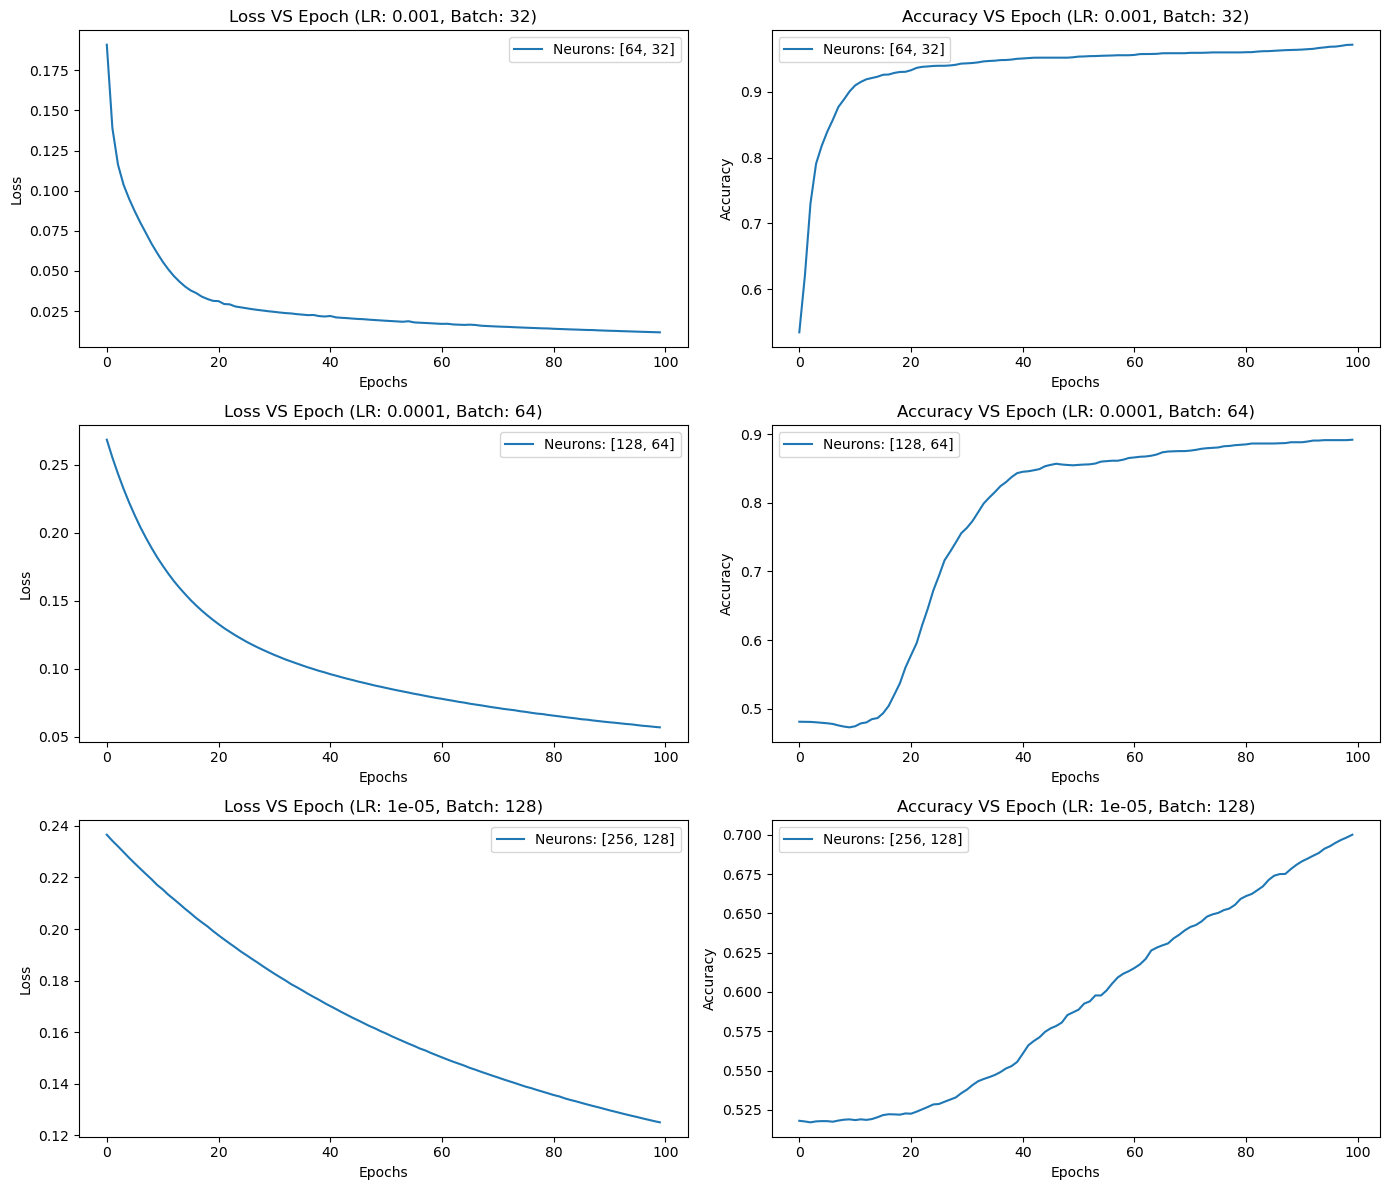

In [15]:
def main_mushroom_hypertuned():
    hyperparameters = [
        {"neurons": [64, 32], "learning_rate": 1e-03, "batch_size": 32},
        {"neurons": [128,64], "learning_rate": 1e-04, "batch_size": 64},
        {"neurons": [256, 128], "learning_rate": 1e-05, "batch_size": 128},
    ]

    results = []

    for params in hyperparameters:
        neurons = params["neurons"]
        lr = params["learning_rate"]
        batch_size = params["batch_size"]
        
        print(f"Training with LR: {lr}, Batch Size: {batch_size}, Neurons: {neurons}")

        nn = NeuralNet(X_train_mushroom.shape[1], 2, neurons)

        losses, accuracy = nn.train_net(
            X_train_mushroom, y_train_mushroom,
            X_test_mushroom, y_test_mushroom,
            batch_size=batch_size, epochs=100, learning_rate=lr
        )

        results.append({
            'learning_rate': lr,
            'batch_size': batch_size,
            'neurons': neurons,
            'losses': losses,
            'accuracy': accuracy,
        })

    loss_data = {(params["learning_rate"], params["batch_size"]): [] for params in hyperparameters}
    acc_data = {(params["learning_rate"], params["batch_size"]): [] for params in hyperparameters}

    for res in results:
        loss_data[(res['learning_rate'], res['batch_size'])].append((res['neurons'], res['losses']))
        acc_data[(res['learning_rate'], res['batch_size'])].append((res['neurons'], res['accuracy']))

    total_plots = len(loss_data) * 2
    cols = 2
    rows = int(np.ceil(total_plots / cols))

    plt.figure(figsize=(14, rows * 4))

    for i, (lr, bs) in enumerate(loss_data.keys()):
        plt.subplot(rows, cols, 2 * i + 1)

        for neurons, losses in loss_data[(lr, bs)]:
            plt.plot(losses, label=f"Neurons: {neurons}")

        plt.title(f"Loss VS Epoch (LR: {lr}, Batch: {bs})")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(rows, cols, 2 * i + 2)

        for neurons, accuracy in acc_data[(lr, bs)]:
            plt.plot(accuracy, label=f"Neurons: {neurons}")

        plt.title(f"Accuracy VS Epoch (LR: {lr}, Batch: {bs})")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.tight_layout()
    plt.show()

main_mushroom_hypertuned()

### 10) Dataset 3: Adult

Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

**IMPORTANT NOTE:** This dataset is much larger than the previous two (48843 instances). If your code runs slow on your own computer, you may exclude parts of this dataset, but you must keep a minimum of 10000 datapoints.

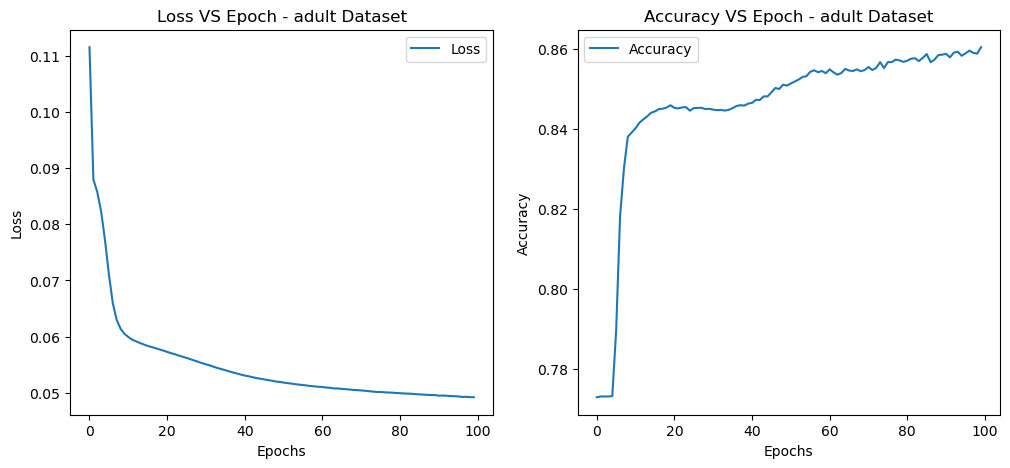

In [16]:
data_adult = pd.read_csv("adult.csv")
data_adult = data_adult.dropna()
data_adult = data_adult.sample(n=10000, random_state=42) 

label_encoders = {}
for col in data_adult.columns:
    le = LabelEncoder()
    data_adult[col] = le.fit_transform(data_adult[col])
    label_encoders[col] = le

X_data_adult = data_adult.drop("income", axis=1).values
#y_data_adult = data_adult["income"].values 
y_data_adult = np.eye(2)[data_adult["income"].values] 

"""sss = StratifiedShuffleSplit(n_splits=1, test_size=10000, random_state=42)
for train_index, _ in sss.split(X_data_adult, y_data_adult):
    X_data_adult_sampled = X_data_adult[train_index]
    y_data_adult_sampled = y_data_adult[train_index]

y_data_adult_sampled = np.eye(2)[y_data_adult_sampled]"""

scaler = StandardScaler()
X_data_adult_scaled = scaler.fit_transform(X_data_adult)

X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(X_data_adult_scaled, y_data_adult, test_size=0.2, random_state=42)

def main_adult(): 
    nn_scaled = NeuralNet(X_train_adult.shape[1], 2, [18, 12])
    loss_scaled, acc_scaled = nn_scaled.train_net(X_train_adult, y_train_adult,X_test_adult,y_test_adult, batch_size=32, epochs=100, learning_rate=0.01, use_validation_data=False)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(loss_scaled, label='Loss')
    plt.title("Loss VS Epoch - adult Dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(acc_scaled, label='Accuracy')
    plt.title("Accuracy VS Epoch - adult Dataset")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

main_adult()

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: learning rate

* Parameter 2: batch size

* Neural network sizes: [[18, 12], [10, 15]]

Training with LR: 0.001, Batch Size: 32, Neurons: [64, 32]
Training with LR: 0.0001, Batch Size: 64, Neurons: [128, 64]
Training with LR: 1e-05, Batch Size: 128, Neurons: [256, 128]


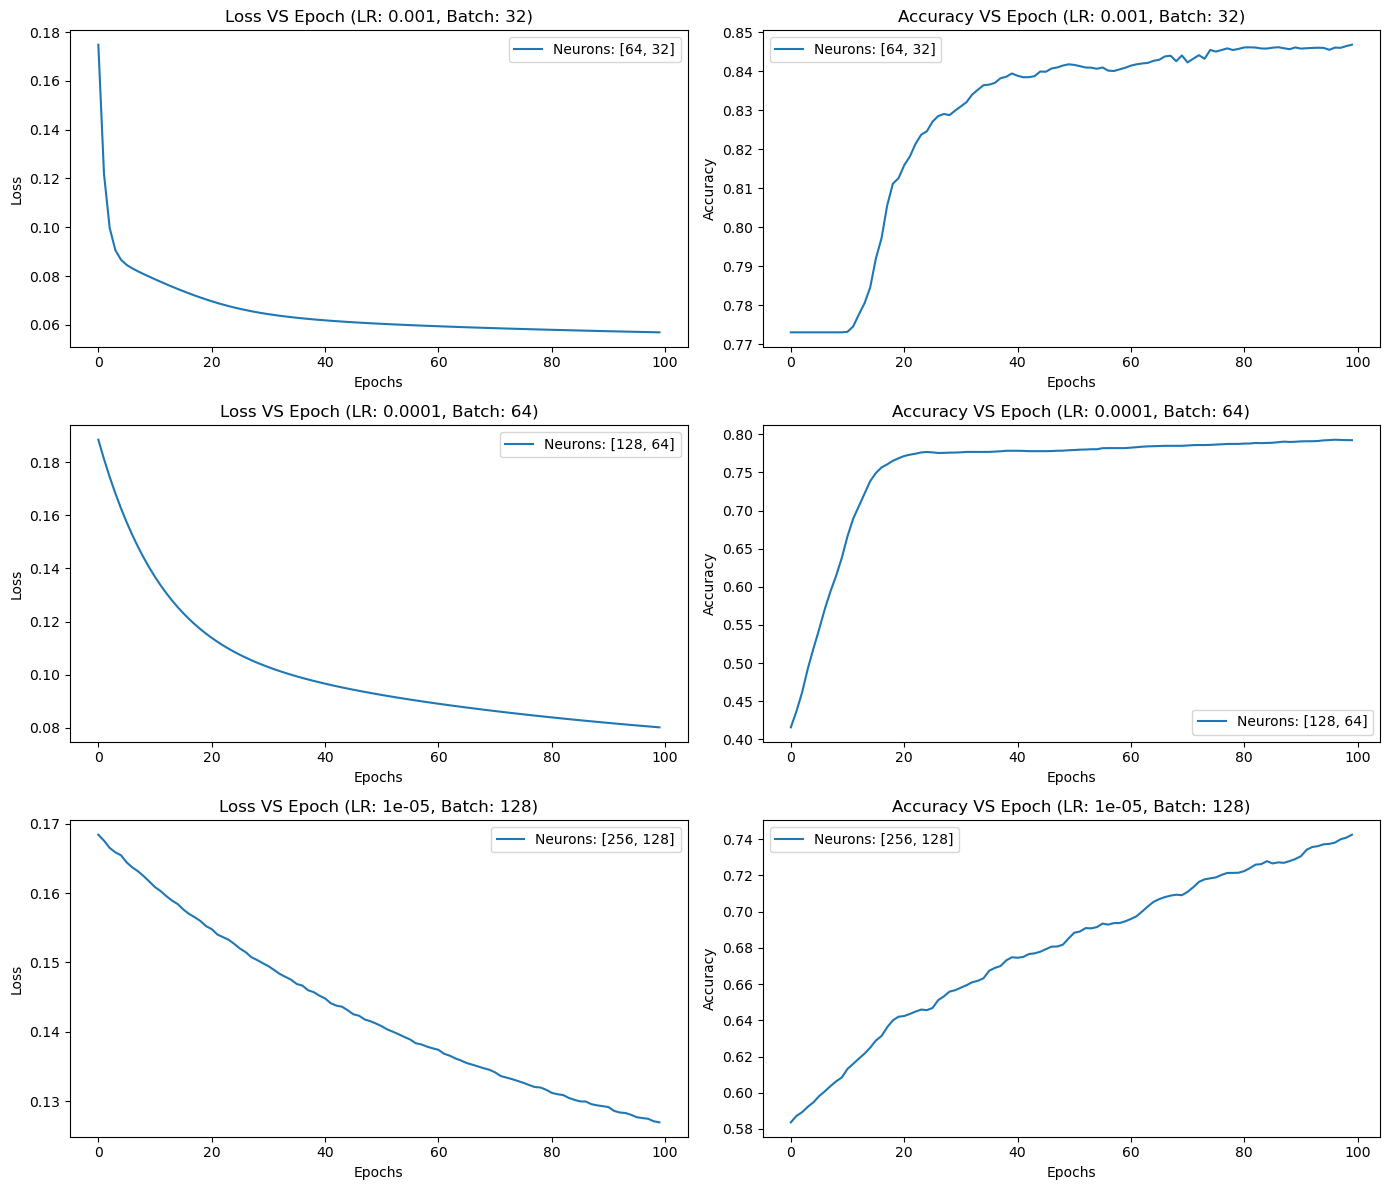

In [17]:
def main_adult_hypertuned():
    hyperparameters = [
        {"neurons": [64, 32], "learning_rate": 1e-03, "batch_size": 32},
        {"neurons": [128,64], "learning_rate": 1e-04, "batch_size": 64},
        {"neurons": [256, 128], "learning_rate": 1e-05, "batch_size": 128},
    ]

    results = []

    for params in hyperparameters:
        neurons = params["neurons"]
        lr = params["learning_rate"]
        batch_size = params["batch_size"]
        
        print(f"Training with LR: {lr}, Batch Size: {batch_size}, Neurons: {neurons}")

        nn = NeuralNet(X_train_adult.shape[1], 2, neurons)

        losses, accuracy = nn.train_net(
            X_train_adult, y_train_adult,
            X_test_adult, y_test_adult,
            batch_size=batch_size, epochs=100, learning_rate=lr
        )

        results.append({
            'learning_rate': lr,
            'batch_size': batch_size,
            'neurons': neurons,
            'losses': losses,
            'accuracy': accuracy,
        })

    loss_data = {(params["learning_rate"], params["batch_size"]): [] for params in hyperparameters}
    acc_data = {(params["learning_rate"], params["batch_size"]): [] for params in hyperparameters}

    for res in results:
        loss_data[(res['learning_rate'], res['batch_size'])].append((res['neurons'], res['losses']))
        acc_data[(res['learning_rate'], res['batch_size'])].append((res['neurons'], res['accuracy']))

    total_plots = len(loss_data) * 2
    cols = 2
    rows = int(np.ceil(total_plots / cols))

    plt.figure(figsize=(14, rows * 4))

    for i, (lr, bs) in enumerate(loss_data.keys()):
        plt.subplot(rows, cols, 2 * i + 1)

        for neurons, losses in loss_data[(lr, bs)]:
            plt.plot(losses, label=f"Neurons: {neurons}")

        plt.title(f"Loss VS Epoch (LR: {lr}, Batch: {bs})")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(rows, cols, 2 * i + 2)

        for neurons, accuracy in acc_data[(lr, bs)]:
            plt.plot(accuracy, label=f"Neurons: {neurons}")

        plt.title(f"Accuracy VS Epoch (LR: {lr}, Batch: {bs})")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.tight_layout()
    plt.show()

main_adult_hypertuned()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why would we want to use different activation functions?

2) Why would we want to use different loss functions?

3) Why are neural networks sensitive to large input values?

4) What is the role of the bias? 

5) What is the purpose of hyper-parameter tuning?

6) A small example neural network will be shown during the oral examination. You will be asked a few basic questions related to the number of weights, biases, inputs and outputs.

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!